In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
np.set_printoptions(precision=2)
pd.set_option('display.precision', 2)

## The gamma distribution

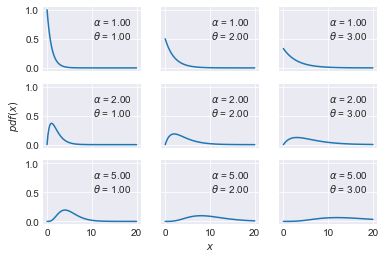

In [2]:
rates = [1, 2, 5]
scales = [1, 2, 3]

x = np.linspace(0, 20, 100)
f, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True)
for i in range(len(rates)):
    for j in range(len(scales)):
        rate = rates[i]
        scale = scales[j]
        rv = stats.gamma(a=rate, scale=scale)
        ax[i,j].plot(x, rv.pdf(x))
        ax[i,j].plot(0, 0, 
        label="$\\alpha$ = {:3.2f}\n$\\theta$ = {:3.2f}".format(rate, scale), alpha=0)
        ax[i,j].legend()
ax[2,1].set_xlabel('$x$')
ax[1,0].set_ylabel('$pdf(x)$')
plt.savefig('B04958_04_00.png', dpi=300, figsize=(5.5, 5.5));

## Simple linear regression

In [3]:
np.random.seed(1)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x 
y = y_real + eps_real

# we can center the data
#x = x - x.mean()
# or standardize the data
#x = (x - x.mean())/x.std()
#y = (y - y.mean())/y.std()

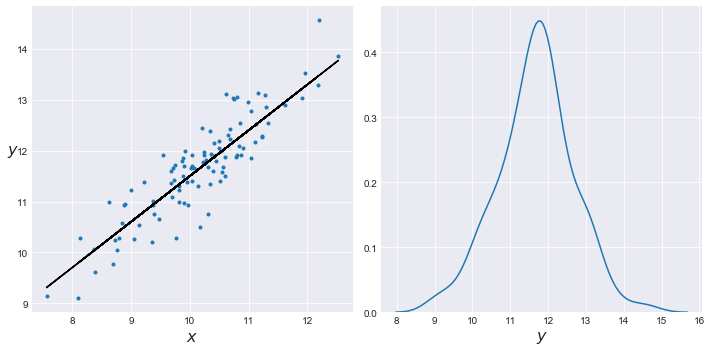

In [4]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'C0.')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_04_02.png', dpi=300, figsize=(5.5, 5.5))

In [5]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = pm.Deterministic('mu', alpha + beta * x)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    # ## In this example we are deliberativelly choosing the metropolis sampler
    step = pm.Metropolis() 
    trace = pm.sample(10000, step=step)   

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 21000/21000 [00:05<00:00, 3745.22draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


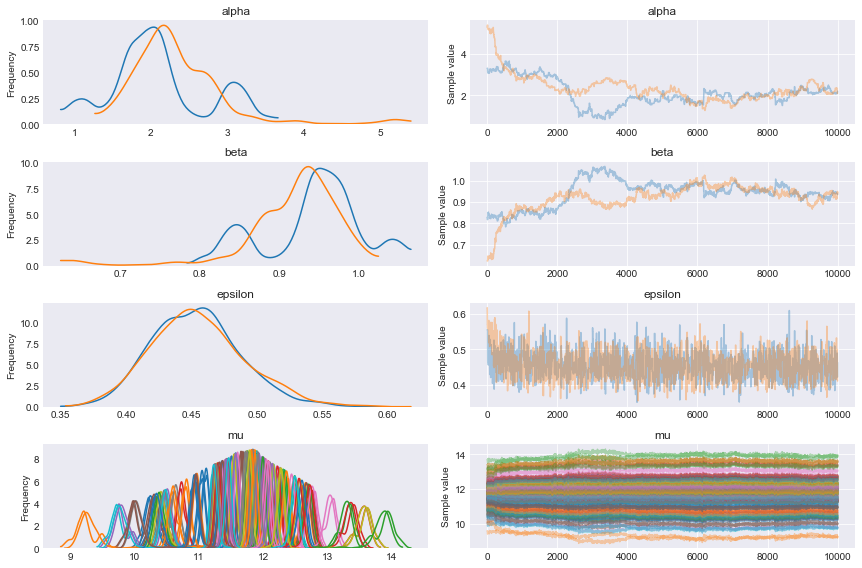

In [6]:
pm.traceplot(trace)
plt.savefig('B04958_04_03.png', dpi=300, figsize=(5.5, 5.5))

In [7]:
#pm.summary(trace)

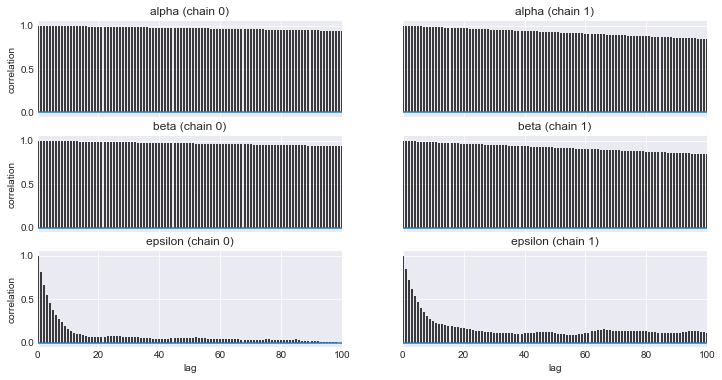

In [8]:
varnames = ['alpha', 'beta', 'epsilon']
pm.autocorrplot(trace, varnames)
plt.savefig('B04958_04_04.png', dpi=300, figsize=(5.5, 5.5));

### Modyfing the data before running the models

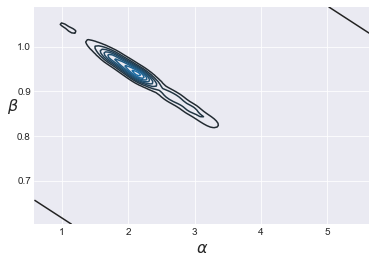

In [9]:
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)
plt.savefig('B04958_04_05.png', dpi=300, figsize=(5.5, 5.5));

### Changing the sampling method

In [10]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = pm.Deterministic('mu', alpha + beta * x)

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    trace_n = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:11<00:00, 436.14draws/s]
The acceptance probability does not match the target. It is 0.8920278698355086, but should be close to 0.8. Try to increase the number of tuning steps.


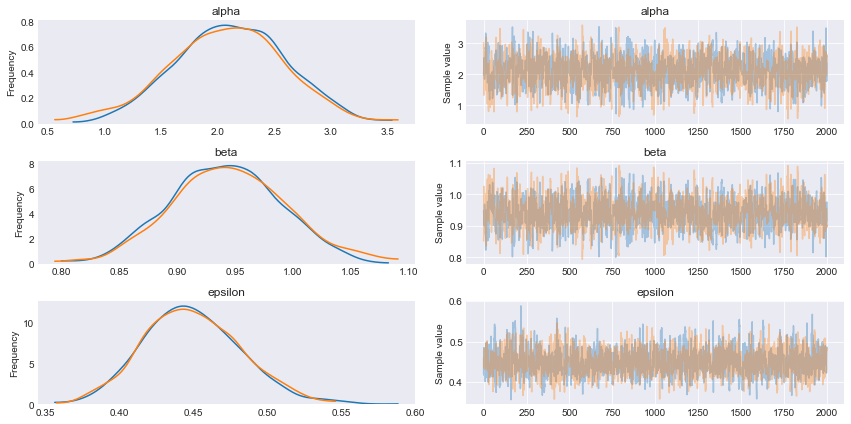

In [11]:
pm.traceplot(trace_n, varnames);

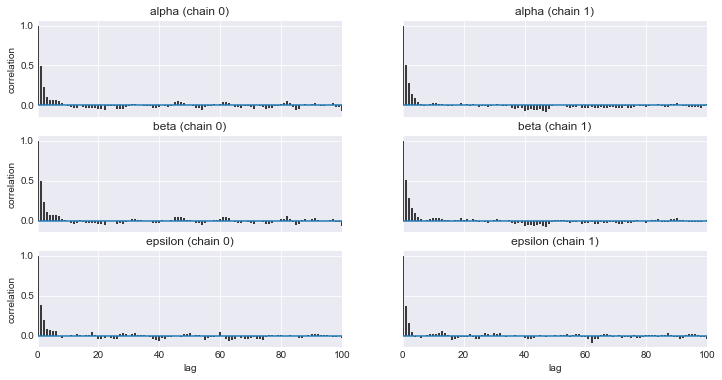

In [12]:
pm.autocorrplot(trace_n, varnames);

In [13]:
pm.summary(trace_n, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,2.10,0.50,1.35e-02,1.10,3.05,1192.76,1.0
beta,0.94,0.05,1.34e-03,0.85,1.04,1173.86,1.0
epsilon,0.45,0.03,7.97e-04,0.38,0.51,1679.74,1.0


### Posterior predictive checks

In [14]:
ppc = pm.sample_posterior_predictive(trace_n, samples=231, model=model_n)

100%|██████████| 231/231 [00:00<00:00, 1966.67it/s]


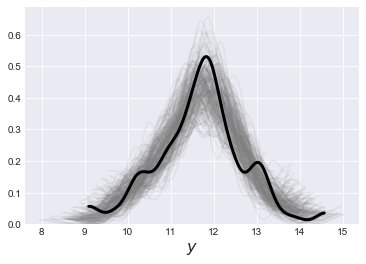

In [15]:
# predicted data
_, ax = plt.subplots()
for y_tilde in ppc['y_pred']:
    pm.kdeplot(y_tilde, alpha=0.1, c='gray', ax=ax)
# actual data
pm.kdeplot(y, linewidth=3, color='k', ax=ax)
    
plt.xlabel('$y$', fontsize=16);

### interpreting the posterior

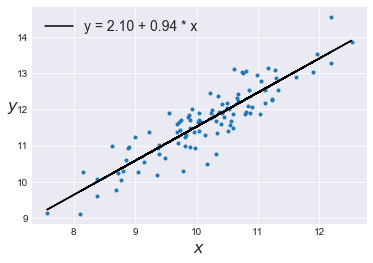

In [16]:
plt.plot(x, y, 'C0.');
alpha_m = trace_n['alpha'].mean()
beta_m = trace_n['beta'].mean()
plt.plot(x, alpha_m + beta_m * x,
         c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)
plt.savefig('B04958_04_06.png', dpi=300, figsize=(5.5, 5.5));

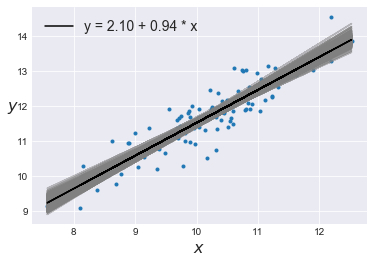

In [17]:
plt.plot(x, y, 'C0.');

idx = range(0, len(trace_n['alpha']), 10)
plt.plot(x, trace_n['alpha'][idx] + trace_n['beta'][idx] *  x[:,np.newaxis], c='gray', alpha=0.5);

plt.plot(x, alpha_m + beta_m * x, c='k',
         label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)
plt.savefig('B04958_04_07.png', dpi=300, figsize=(5.5, 5.5));

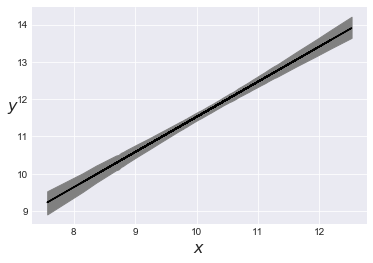

In [18]:
plt.plot(x, alpha_m + beta_m * x, c='k',
         label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

idx = np.argsort(x)
x_ord = x[idx]
sig = pm.hpd(trace_n['mu'], alpha=.02)[idx]
plt.fill_between(x_ord, sig[:,0], sig[:,1], color='gray')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_08.png', dpi=300, figsize=(5.5, 5.5));

In [19]:
ppc = pm.sample_posterior_predictive(trace_n, samples=1000, model=model_n)

100%|██████████| 1000/1000 [00:00<00:00, 2415.99it/s]


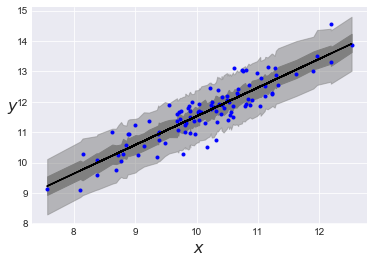

In [20]:
plt.plot(x, y, 'b.')
plt.plot(x, alpha_m + beta_m * x, c='k', label='y = {:.2f} + {:.2f} * x'.format(alpha_m, beta_m))

sig0 = pm.hpd(ppc['y_pred'], alpha=0.5)[idx]
sig1 = pm.hpd(ppc['y_pred'], alpha=0.05)[idx]
plt.fill_between(x_ord, sig0[:,0], sig0[:,1], color='gray', alpha=1)
plt.fill_between(x_ord, sig1[:,0], sig1[:,1], color='gray', alpha=0.5)

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_09.png', dpi=300, figsize=(5.5, 5.5));

## Pearson correlation coefficient

In [21]:
with pm.Model() as model_n:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    
    mu = alpha + beta * x
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    rb = pm.Deterministic('rb', (beta * x.std() / y.std()) ** 2)

    y_mean = y.mean()
    ss_reg = pm.math.sum((mu - y_mean) ** 2)
    ss_tot = pm.math.sum((y - y_mean) ** 2)
    rss = pm.Deterministic('rss', ss_reg/ss_tot)
    
    trace_n = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:11<00:00, 449.36draws/s]


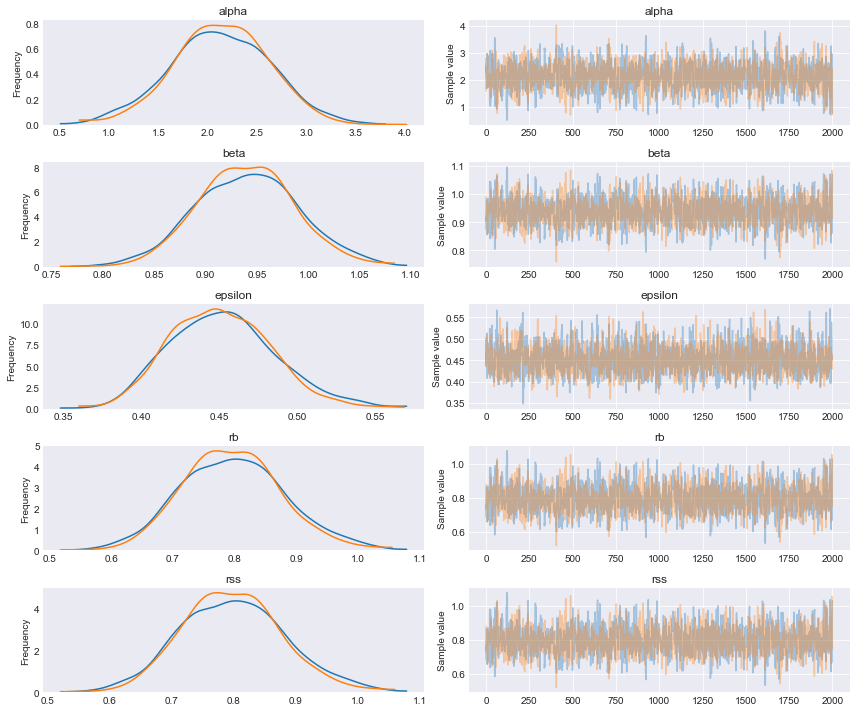

In [22]:
pm.traceplot(trace_n)
plt.savefig('B04958_04_10.png', dpi=300, figsize=(5.5, 5.5));

A better approach to compute R^2 is to use the function `r2_score` implemented in PyMC3.

In [23]:
ppc = pm.sample_posterior_predictive(trace_n, 1000, model=model_n)
pm.r2_score(y, ppc['y_pred'].mean(0))

100%|██████████| 1000/1000 [00:00<00:00, 1481.74it/s]


r2_r(r2_median=0.8, r2_mean=0.8, r2_std=0.0)

In [24]:
pm.summary(trace_n)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,2.13,0.49,1.15e-02,1.09,3.04,1384.73,1.0
beta,0.94,0.05,1.12e-03,0.85,1.04,1387.06,1.0
epsilon,0.45,0.03,7.54e-04,0.39,0.52,1704.55,1.0
rb,0.80,0.08,1.91e-03,0.64,0.96,1382.34,1.0
rss,0.80,0.08,1.91e-03,0.65,0.97,1382.21,1.0


### The multivariate normal distribution 
Actually the bivariate

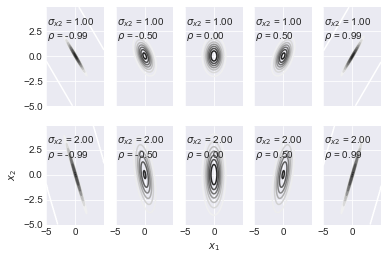

In [25]:
sigma_x1 = 1
sigmas_x2 = [1, 2]
rhos = [-0.99, -0.5, 0, 0.5, 0.99]

k, l = np.mgrid[-5:5:.1, -5:5:.1]
pos = np.empty(k.shape + (2,))
pos[:, :, 0] = k; pos[:, :, 1] = l

f, ax = plt.subplots(len(sigmas_x2), len(rhos), sharex=True, sharey=True)
#f.figure(figsize=(5, 1))
for i in range(2):
    for j in range(5):
        sigma_x2 = sigmas_x2[i]
        rho = rhos[j]
        cov = [[sigma_x1**2, sigma_x1*sigma_x2*rho], [sigma_x1*sigma_x2*rho, sigma_x2**2]]
        rv = stats.multivariate_normal([0, 0], cov)
        ax[i,j].contour(k, l, rv.pdf(pos))
        ax[i,j].plot(0, 0, 
        label="$\\sigma_{{x2}}$ = {:3.2f}\n$\\rho$ = {:3.2f}".format(sigma_x2, rho), alpha=0)
        ax[i,j].legend()
ax[1,2].set_xlabel('$x_1$')
ax[1,0].set_ylabel('$x_2$')
plt.savefig('B04958_04_11.png', dpi=300, figsize=(5.5, 5.5));

In [26]:
data = np.stack((x, y)).T

In [27]:
with pm.Model() as pearson_model:
    
    mu = pm.Normal('mu', mu=data.mean(0), sd=10, shape=2)
    
    sigma_1 = pm.HalfNormal('simga_1', 10)
    sigma_2 = pm.HalfNormal('sigma_2', 10)
    rho = pm.Uniform('rho', -1, 1)
    
    cov = pm.math.stack(([sigma_1**2, sigma_1*sigma_2*rho], [sigma_1*sigma_2*rho, sigma_2**2]))
    
    y_pred = pm.MvNormal('y_pred', mu=mu, cov=cov, observed=data)

    trace_p = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rho, sigma_2, simga_1, mu]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:09<00:00, 312.57draws/s]


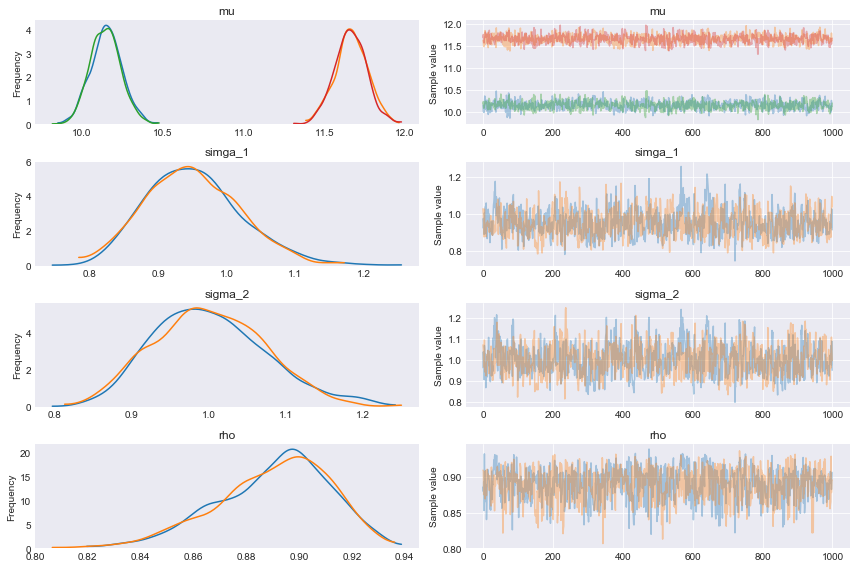

In [28]:
pm.traceplot(trace_p);
plt.savefig('B04958_04_12.png', dpi=300, figsize=(5.5, 5.5));

In [29]:
pm.summary(trace_p)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu__0,10.15,0.09,2.99e-03,9.97,10.34,1092.03,1.0
mu__1,11.66,0.10,3.10e-03,11.46,11.86,1103.89,1.0
simga_1,0.95,0.07,2.68e-03,0.82,1.09,560.84,1.0
sigma_2,1.00,0.07,2.80e-03,0.87,1.14,559.80,1.0
rho,0.89,0.02,7.21e-04,0.85,0.93,791.64,1.0


## Robust linear regression

In [30]:
ans = sns.load_dataset('anscombe')
x_3 = ans[ans.dataset == 'III']['x'].values
y_3 = ans[ans.dataset == 'III']['y'].values

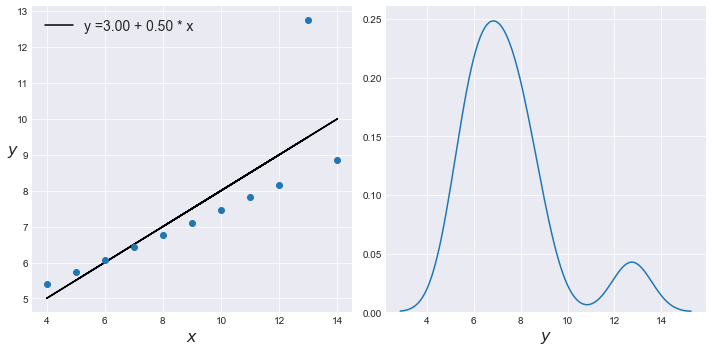

In [31]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]
plt.plot(x_3, (alpha_c + beta_c* x_3), 'k',
         label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_3, y_3, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_3);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()
plt.savefig('B04958_04_13.png', dpi=300, figsize=(5.5, 5.5));

In [32]:
with pm.Model() as model_t:
    alpha = pm.Normal('alpha', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Deterministic('nu', pm.Exponential('nu_', 1/29) + 1)
    
    y_pred = pm.StudentT('y_pred', mu=alpha + beta * x_3,
                         sd=epsilon, nu=nu, observed=y_3)
    
    trace_t = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu_, epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:11<00:00, 433.92draws/s]
The number of effective samples is smaller than 25% for some parameters.


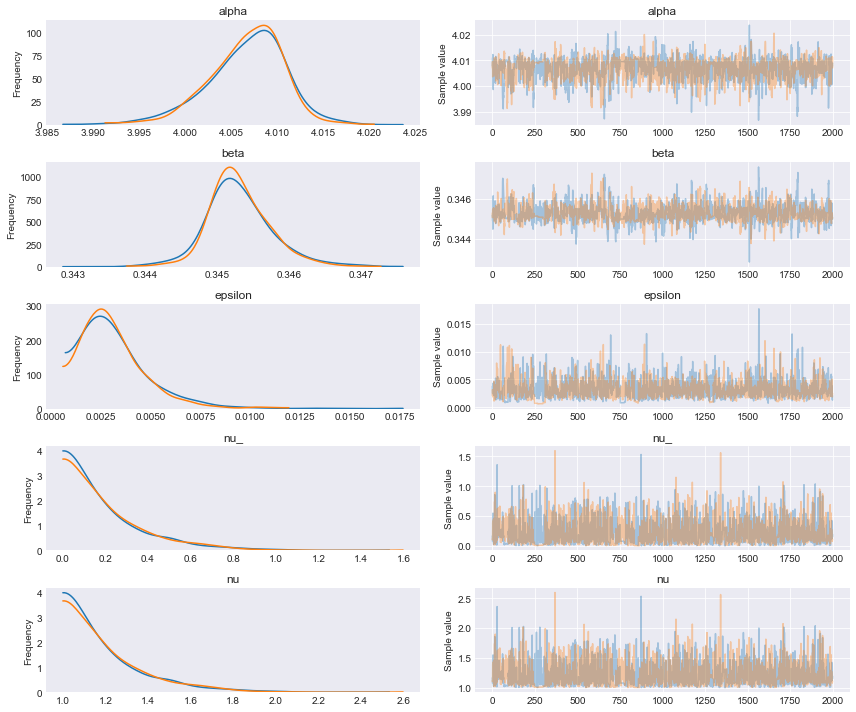

In [33]:
pm.traceplot(trace_t);

In [34]:
pm.summary(trace_t)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,4.01e+00,4.15e-03,1.20e-04,4.00e+00,4.01e+00,1048.36,1.0
beta,3.45e-01,4.38e-04,1.23e-05,3.44e-01,3.46e-01,1079.01,1.0
epsilon,3.17e-03,1.69e-03,6.08e-05,6.01e-04,6.40e-03,574.73,1.0
nu_,2.03e-01,1.96e-01,4.55e-03,2.58e-04,6.13e-01,1705.14,1.0
nu,1.20e+00,1.96e-01,4.55e-03,1.00e+00,1.61e+00,1705.14,1.0


In [35]:
#pm.autocorrplot(cadena_t, varnames);

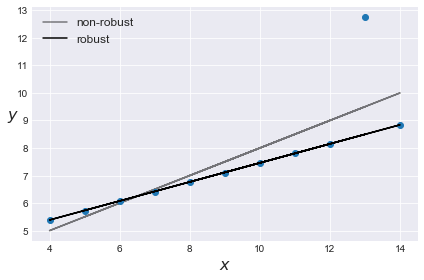

In [36]:
beta_c, alpha_c = stats.linregress(x_3, y_3)[:2]

plt.plot(x_3, (alpha_c + beta_c * x_3), 'k', label='non-robust', alpha=0.5)
plt.plot(x_3, y_3, 'C0o')
alpha_m = trace_t['alpha'].mean()
beta_m = trace_t['beta'].mean()
plt.plot(x_3, alpha_m + beta_m * x_3, c='k', label='robust')

plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=2, fontsize=12)
plt.tight_layout()

plt.savefig('B04958_04_14.png', dpi=300, figsize=(5.5, 5.5));

In [37]:
ppc = pm.sample_posterior_predictive(trace_t, samples=200, model=model_t, random_seed=2)

100%|██████████| 200/200 [00:00<00:00, 1300.59it/s]


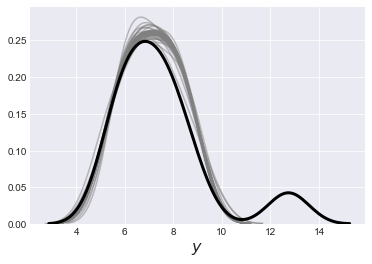

In [38]:
# predicted data
for y_tilde in ppc['y_pred']:
    sns.kdeplot(y_tilde, alpha=0.5, color='gray')

# actual data
sns.kdeplot(y_3, linewidth=3, color='k')
plt.xlabel('$y$', fontsize=16)
plt.savefig('B04958_04_15.png', dpi=300, figsize=(5.5, 5.5));

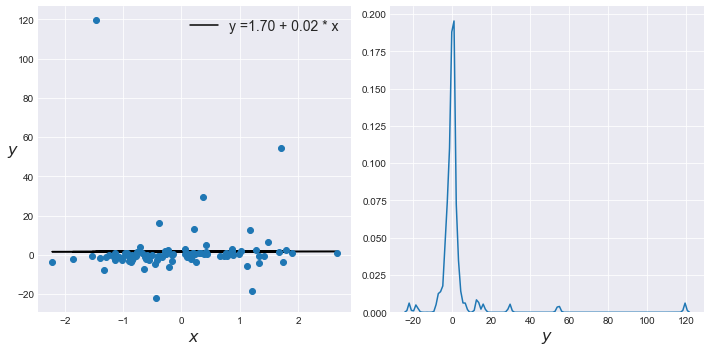

In [39]:
np.random.seed(314)
x_4 = np.random.normal(size=100)
y_4 = x_4 + np.random.standard_t(df=1, size=100) # experiments with different values of df

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
beta_c, alpha_c = stats.linregress(x_4, y_4)[:2]
plt.plot(x_4, (alpha_c + beta_c* x_4), 'k', 
         label='y ={:.2f} + {:.2f} * x'.format(alpha_c, beta_c))
plt.plot(x_4, y_4, 'C0o')
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', rotation=0, fontsize=16)
plt.legend(loc=0, fontsize=14)
plt.subplot(1,2,2)
sns.kdeplot(y_4);
plt.xlabel('$y$', fontsize=16)
plt.tight_layout()

## Hierarchical linear regression

In [40]:
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m  + eps_real

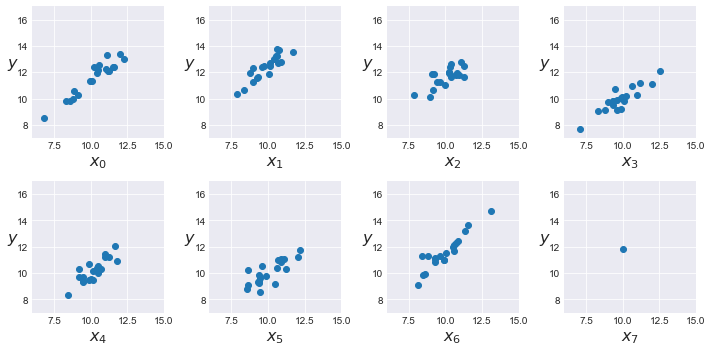

In [41]:
plt.figure(figsize=(10,5))
j, k = 0, N
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B04958_04_16.png', dpi=300, figsize=(5.5, 5.5));

In [42]:
x_centered = x_m - x_m.mean()

In [43]:
with pm.Model() as unpooled_model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu= alpha_tmp[idx] + beta[idx] * x_centered,
                         sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 

    trace_up = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, epsilon, beta, alpha_tmp]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:07<00:00, 712.92draws/s] 


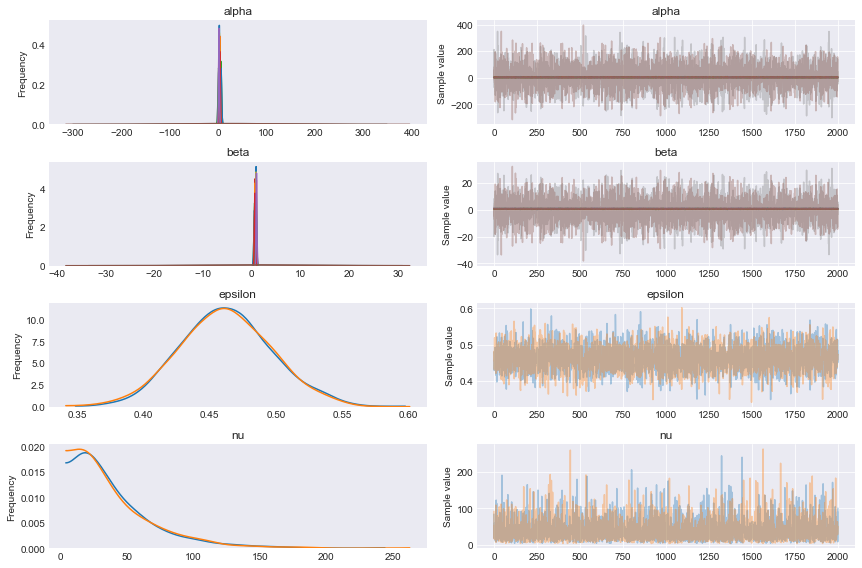

In [44]:
varnames=['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace_up, varnames)
plt.savefig('B04958_04_17.png', dpi=300, figsize=(5.5, 5.5));

In [45]:
#pm.autocorrplot(trace_up, varnames=[epsilon, nu]);

In [46]:
pm.summary(trace_up, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,2.42,0.80,8.07e-03,0.91,4.02,10858.81,1.0
alpha__1,3.71,1.15,1.13e-02,1.55,5.98,9966.11,1.0
alpha__2,5.69,1.29,1.43e-02,3.08,8.12,9474.67,1.0
alpha__3,3.04,0.86,9.38e-03,1.40,4.72,8089.25,1.0
alpha__4,1.30,1.39,1.47e-02,-1.33,4.03,8640.15,1.0
alpha__5,3.22,1.04,1.01e-02,1.26,5.35,10107.48,1.0
alpha__6,1.75,0.89,1.05e-02,0.02,3.49,8218.92,1.0
alpha__7,9.78,99.70,1.07e+00,-180.75,209.16,8028.10,1.0
beta__0,0.90,0.08,8.06e-04,0.74,1.05,10613.08,1.0
beta__1,0.88,0.12,1.13e-03,0.65,1.09,10016.15,1.0


In [47]:
with pm.Model() as hierarchical_model:
    # hyper-priors
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=25)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 25)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=25)
    beta_sd = pm.HalfCauchy('beta_sd', 25)

    # a prioris
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)

    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
    
    trace_hm = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, epsilon, beta, alpha_tmp, beta_sd, beta_mu, alpha_tmp_sd, alpha_tmp_mu]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:22<00:00, 358.07draws/s]
There were 56 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7155041606517678, but should be close to 0.8. Try to increase the number of tuning steps.
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.64360169276755, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


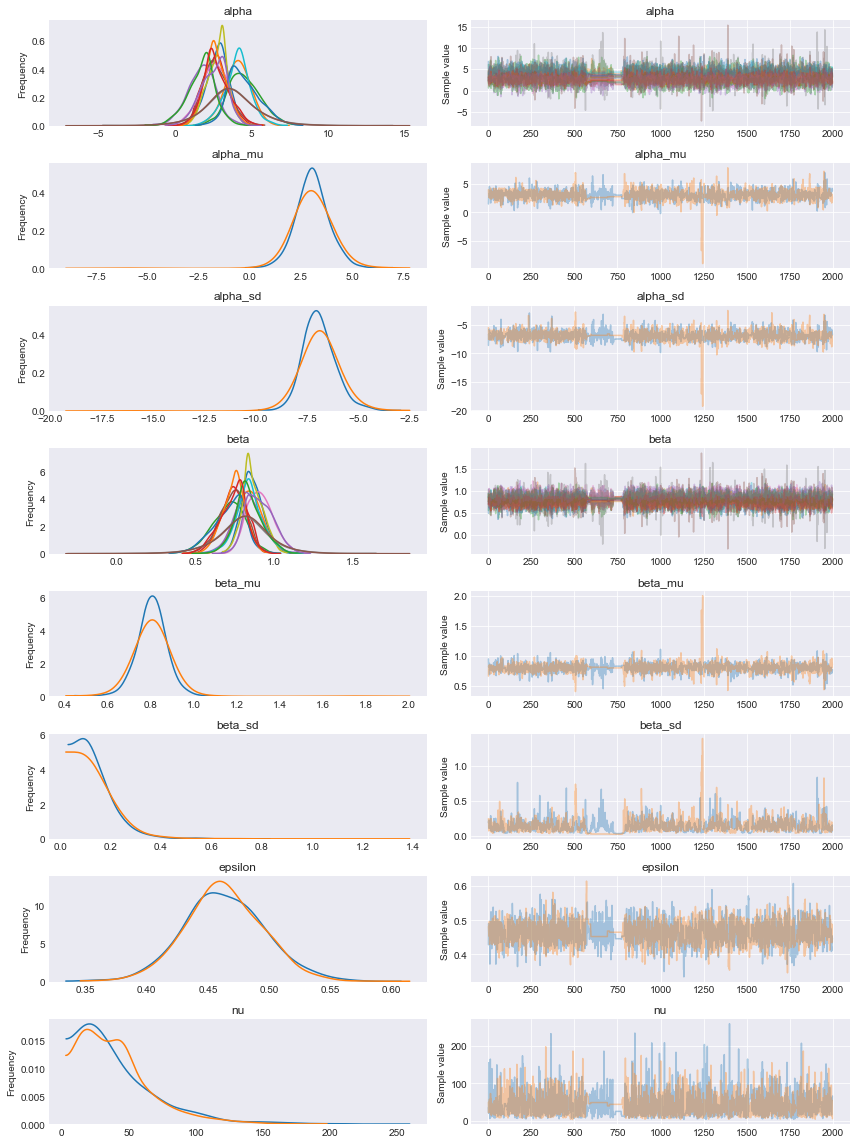

In [48]:
varnames=['alpha', 'alpha_mu', 'alpha_sd', 'beta',
          'beta_mu', 'beta_sd', 'epsilon', 'nu']
pm.traceplot(trace_hm, varnames)
plt.savefig('B04958_04_19.png', dpi=300, figsize=(5.5, 5.5));

In [49]:
pm.summary(trace_hm, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,2.75,0.69,1.45e-02,1.36,4.04,2543.49,1.0
alpha__1,4.06,0.84,1.52e-02,2.27,5.68,3211.83,1.0
alpha__2,4.50,1.05,3.40e-02,2.71,6.82,592.73,1.0
alpha__3,2.63,0.75,2.23e-02,1.26,4.15,1022.30,1.0
alpha__4,1.71,0.92,1.83e-02,-0.25,3.45,2590.68,1.0
alpha__5,2.66,0.85,2.35e-02,1.06,4.42,1093.95,1.0
alpha__6,2.50,0.85,2.88e-02,0.73,4.01,522.11,1.0
alpha__7,3.60,1.75,3.13e-02,0.06,7.17,2964.54,1.0
alpha_mu,3.02,0.93,2.46e-02,1.44,4.70,1216.57,1.0
alpha_sd,-6.91,0.93,2.42e-02,-8.49,-5.23,1202.02,1.0


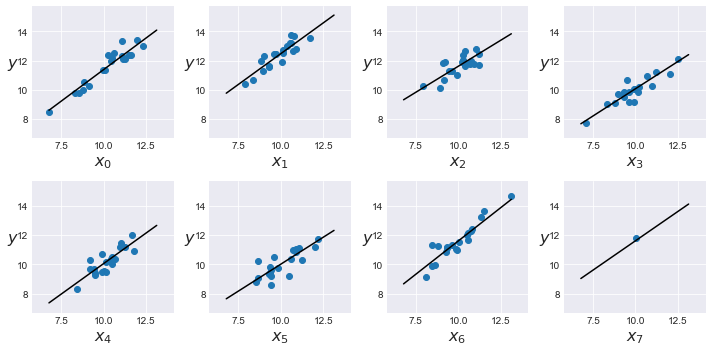

In [50]:
plt.figure(figsize=(10,5))
j, k = 0, N
x_range = np.linspace(x_m.min(), x_m.max(), 10)
for i in range(M):
    plt.subplot(2, 4, i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    alfa_m = trace_hm['alpha'][:,i].mean()
    beta_m = trace_hm['beta'][:,i].mean()
    plt.plot(x_range, alfa_m + beta_m * x_range, c='k',
             label='y = {:.2f} + {:.2f} * x'.format(alfa_m, beta_m))
    plt.xlim(x_m.min()-1, x_m.max()+1)
    plt.ylim(y_m.min()-1, y_m.max()+1)
    j += N
    k += N
plt.tight_layout()
plt.savefig('B04958_04_20.png', dpi=300, figsize=(5.5, 5.5));

## Polynomial regression

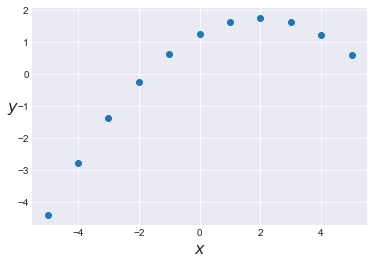

In [51]:
#ans = sns.load_dataset('anscombe')
x_2 = ans[ans.dataset == 'II']['x'].values
y_2 = ans[ans.dataset == 'II']['y'].values
x_2 = x_2 - x_2.mean()
y_2 = y_2 - y_2.mean()

plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.savefig('B04958_04_21.png', dpi=300, figsize=(5.5, 5.5))

In [52]:
with pm.Model() as model_poly:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta1 = pm.Normal('beta1', mu=0, sd=1)
    beta2 = pm.Normal('beta2', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + beta1 * x_2 + beta2 * x_2**2
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_2)
    
    trace_poly = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta2, beta1, alpha]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:07<00:00, 703.40draws/s] 
The acceptance probability does not match the target. It is 0.900265250837282, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9346639801922949, but should be close to 0.8. Try to increase the number of tuning steps.


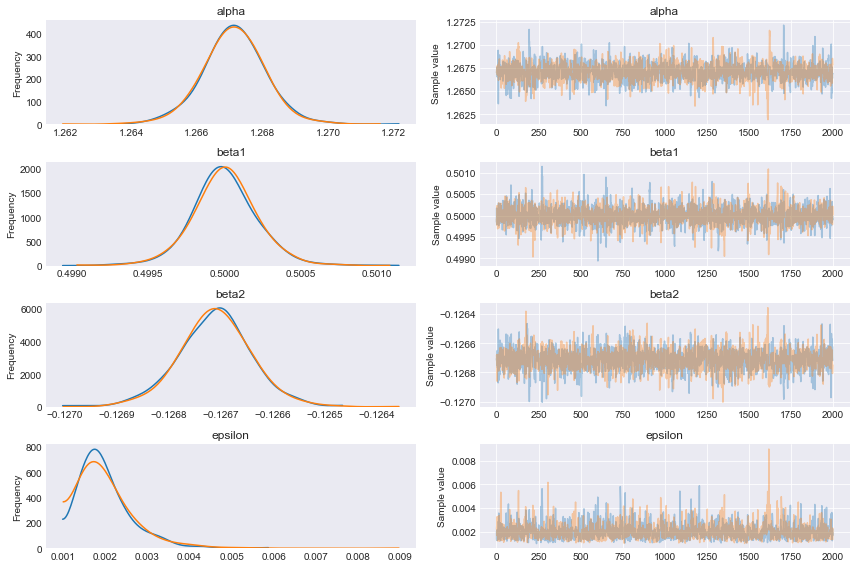

In [53]:
pm.traceplot(trace_poly)
plt.savefig('B04958_04_22.png', dpi=300, figsize=(5.5, 5.5))

In [54]:
pm.summary(trace_poly)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.27e+00,9.58e-04,2.26e-05,1.27e+00,1.27e+00,1484.15,1.0
beta1,5.00e-01,2.11e-04,4.61e-06,5.00e-01,5.00e-01,2556.97,1.0
beta2,-1.27e-01,7.03e-05,1.51e-06,-1.27e-01,-1.27e-01,1709.86,1.0
epsilon,2.02e-03,6.55e-04,1.98e-05,1.05e-03,3.28e-03,1131.08,1.0


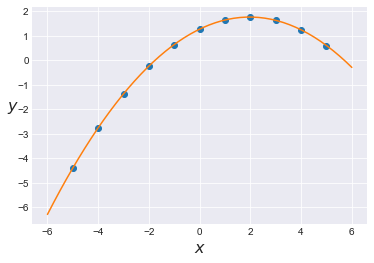

In [55]:
x_p = np.linspace(-6, 6)
y_p = trace_poly['alpha'].mean() + trace_poly['beta1'].mean() * x_p + trace_poly['beta2'].mean() * x_p**2
plt.scatter(x_2, y_2)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.plot(x_p, y_p, c='C1')
plt.savefig('B04958_04_23.png', dpi=300, figsize=(5.5, 5.5))

## Multiple Linear regression

In [56]:
np.random.seed(314)
N = 100
alpha_real = 2.5
beta_real = [0.9, 1.5]
eps_real = np.random.normal(0, 0.5, size=N)

X = np.array([np.random.normal(i, j, N) for i,j in zip([10, 2], [1, 1.5])])
X_mean = X.mean(axis=1, keepdims=True)
X_centered = X - X_mean
y = alpha_real + np.dot(beta_real, X) + eps_real

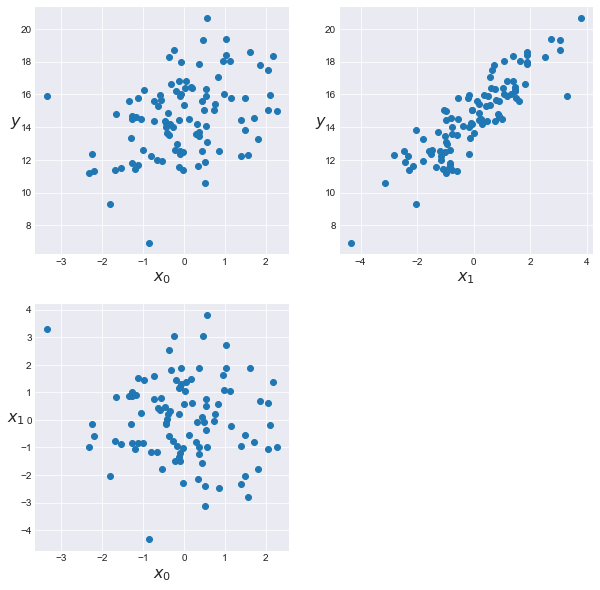

In [57]:
def scatter_plot(x, y):
    plt.figure(figsize=(10, 10))
    for idx, x_i in enumerate(x):
        plt.subplot(2, 2, idx+1)
        plt.scatter(x_i, y)
        plt.xlabel('$x_{}$'.format(idx), fontsize=16)
        plt.ylabel('$y$', rotation=0, fontsize=16)

    plt.subplot(2, 2, idx+2)
    plt.scatter(x[0], x[1])
    plt.xlabel('$x_{}$'.format(idx-1), fontsize=16)
    plt.ylabel('$x_{}$'.format(idx), rotation=0, fontsize=16)

scatter_plot(X_centered, y)
plt.savefig('B04958_04_25.png', dpi=300, figsize=(5.5, 5.5))

In [58]:
with pm.Model() as model_mlr:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha_tmp + pm.math.dot(beta, X_centered)

    alpha = pm.Deterministic('alpha', alpha_tmp - pm.math.dot(beta, X_mean)) 

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    trace_mlr = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha_tmp]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:09<00:00, 1112.87draws/s]


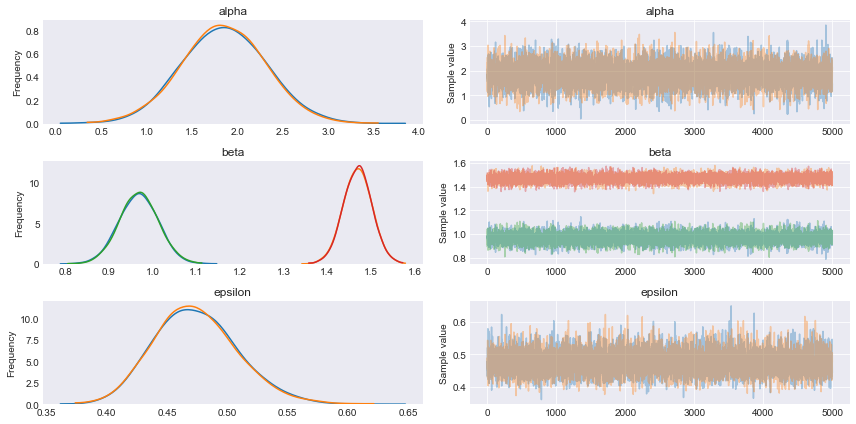

In [59]:
varnames = ['alpha', 'beta','epsilon']
pm.traceplot(trace_mlr, varnames)
plt.savefig('B04958_04_26.png', dpi=300, figsize=(5.5, 5.5));

In [60]:
pm.summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,1.85,0.46,3.99e-03,0.95,2.75,11432.66,1.0
beta__0,0.97,0.04,3.77e-04,0.88,1.05,12104.49,1.0
beta__1,1.47,0.03,2.74e-04,1.40,1.53,13158.03,1.0
epsilon,0.47,0.03,3.42e-04,0.41,0.54,10530.52,1.0


In [61]:
pm.summary(trace_mlr, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,1.85,0.46,3.99e-03,0.95,2.75,11432.66,1.0
beta__0,0.97,0.04,3.77e-04,0.88,1.05,12104.49,1.0
beta__1,1.47,0.03,2.74e-04,1.40,1.53,13158.03,1.0
epsilon,0.47,0.03,3.42e-04,0.41,0.54,10530.52,1.0


## Confounding variables and redundant variables

In [62]:
np.random.seed(314)
N = 100
x_1 = np.random.normal(size=N)
x_2 = x_1 + np.random.normal(size=N, scale=1)
#x_2 = x_1 + np.random.normal(size=N, scale=0.01)  
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1, x_2))

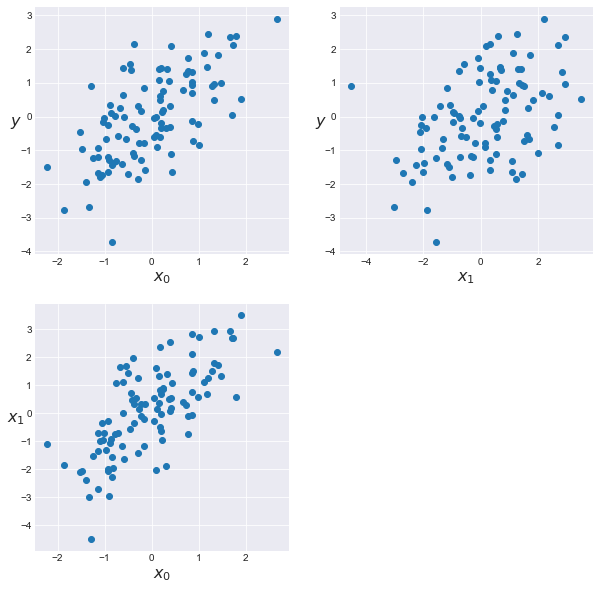

In [63]:
scatter_plot(X, y)
plt.savefig('B04958_04_27.png', dpi=300, figsize=(5.5, 5.5));

In [64]:
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]
    
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
 
    trace_red = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:07<00:00, 1458.10draws/s]


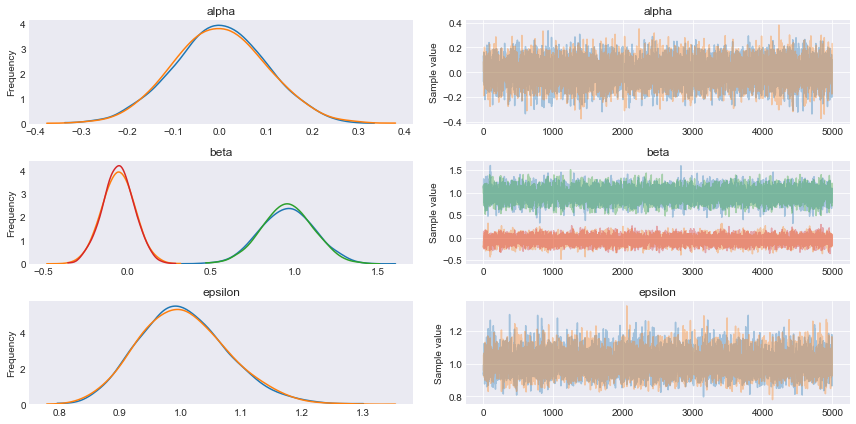

In [65]:
pm.traceplot(trace_red)
plt.savefig('B04958_04_28.png', dpi=300, figsize=(5.5, 5.5))

In [66]:
pm.summary(trace_red)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,3.12e-04,0.10,9.79e-04,-0.19,0.19,9762.86,1.0
beta__0,9.59e-01,0.16,1.49e-03,0.66,1.26,7540.05,1.0
beta__1,-5.29e-02,0.10,1.02e-03,-0.23,0.14,7170.48,1.0
epsilon,1.01e+00,0.07,7.28e-04,0.86,1.15,7714.32,1.0


Text(0, 0.5, '$\\beta_2$')

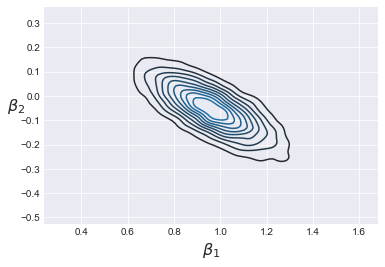

In [67]:
sns.kdeplot(trace_red['beta'][:,0], trace_red['beta'][:,1])
plt.xlabel(r'$\beta_1$', fontsize=16)
plt.ylabel(r'$\beta_2$', fontsize=16, rotation=0)
#plt.savefig('B04958_04_29.png', dpi=300, figsize=(5.5, 5.5));

GridSpec(1, 2, width_ratios=[3, 1])

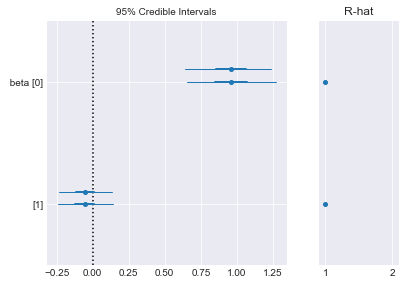

In [68]:
pm.forestplot(trace_red, varnames=['beta'])
#plt.savefig('B04958_04_30.png', dpi=300, figsize=(5.5, 5.5))

## Masking effect variables

In [69]:
np.random.seed(314)
N = 100
r = 0.8
x_0 = np.random.normal(size=N)
x_1 = np.random.normal(loc=x_0 * r, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(loc=x_0 - x_1)
X = np.vstack((x_0, x_1))

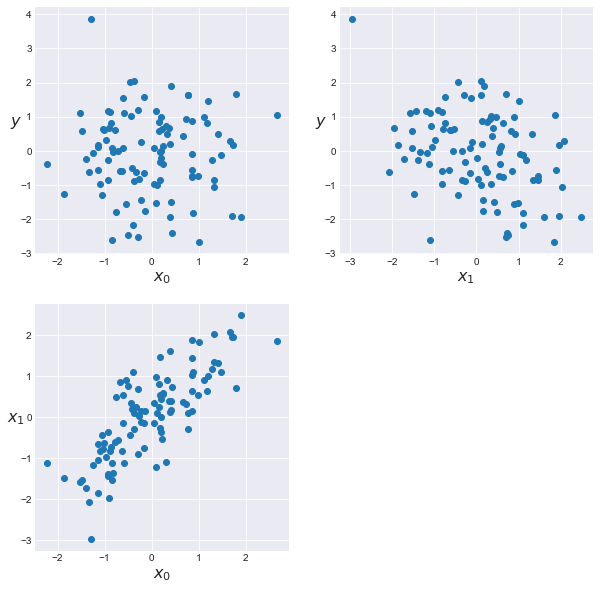

In [70]:
scatter_plot(X, y)
plt.savefig('B04958_04_31.png', dpi=300, figsize=(5.5, 5.5));

In [71]:
with pm.Model() as model_ma:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    #beta = pm.Normal('beta', mu=0, sd=10)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    #mu = alpha + beta * X[0]

    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    
    trace_ma = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:06<00:00, 1573.56draws/s]


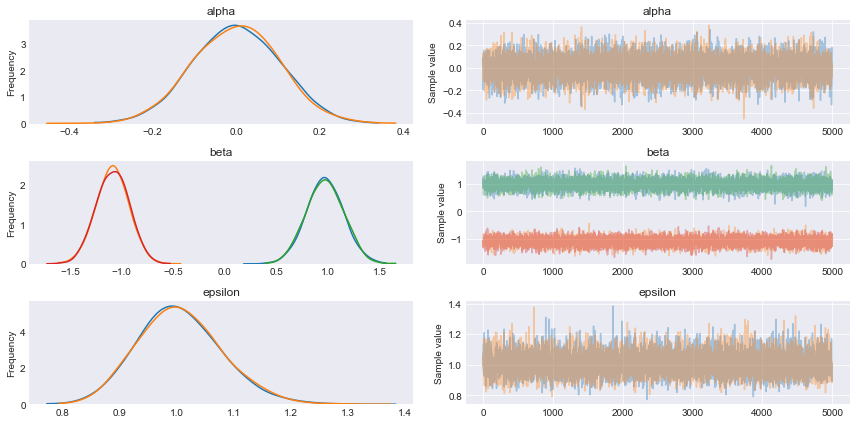

In [72]:
pm.traceplot(trace_ma)
plt.savefig('B04958_04_32.png', dpi=300, figsize=(5.5, 5.5));

In [73]:
pm.summary(trace_ma)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,4.92e-04,0.10,1.14e-03,-0.20,0.21,9417.94,1.0
beta__0,9.73e-01,0.18,2.27e-03,0.61,1.32,6471.19,1.0
beta__1,-1.09e+00,0.16,1.94e-03,-1.40,-0.79,6500.79,1.0
epsilon,1.01e+00,0.07,7.10e-04,0.86,1.15,8731.32,1.0


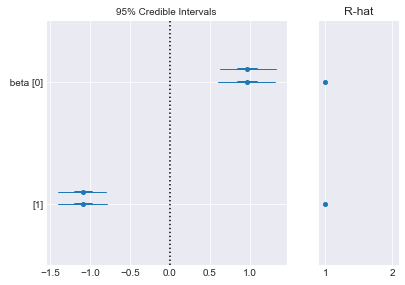

In [74]:
pm.forestplot(trace_ma, varnames=['beta']);
plt.savefig('B04958_04_33.png', dpi=300, figsize=(5.5, 5.5));

In [75]:
import sys, IPython, scipy, matplotlib, platform
print("Esta notebook fue creada en una computadora %s corriendo %s y usando:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__))

Esta notebook fue creada en una computadora x86_64 corriendo debian buster/sid y usando:
Python 3.6.7
IPython 7.0.1
PyMC3 3.6.rc1
NumPy 1.14.2
SciPy 1.1.0
Matplotlib 3.0.2
Seaborn 0.9.0

